# Initialization



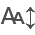

In [1]:
%load_ext autoreload
%autoreload 3

from collections.abc import Callable, Iterable
from datetime import timedelta
from itertools import chain
from pathlib import Path

import contextily
import dask.bag as db
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

from bdproject.local_cluster import local_cluster_start
from bdproject.notebook import init, savefig
from bdproject.paths import (
    get_paths_original_fhv,
    get_paths_original_fhvhv,
    get_paths_original_green,
    get_paths_original_yellow,
    get_ym_from_fname,
)
from bdproject.shapefile import get_gdf_shapefile
from bdproject.slurm_cluster import RUNNING_INSIDE_CLUSTER, slurm_cluster_start

init()

In [2]:
client = (
    slurm_cluster_start("6GiB", 8, 2)
    if RUNNING_INSIDE_CLUSTER
    else local_cluster_start("6GiB")
)

Dashboard at 153.5.72.16:8787


# Anomaly detection


## Initialization


In [3]:
def detect_anomalies(
    paths: Iterable[Path],
    fn: Callable[[Path, int], dict[str, int]],
) -> pl.DataFrame:
    def wrapper(p: Path):
        year, _ = get_ym_from_fname(p)
        return year, fn(p, year)

    def combine(total_a: dict[str, int] | None, total_b: dict[str, int] | None):
        if total_a is None:
            return total_b
        if total_b is None:
            return total_a
        return {k: v + total_b[k] for k, v in total_a.items()}

    def binop(total: dict[str, int] | None, x: tuple[int, dict[str, int]]):
        if total is None:
            return x[1]
        return combine(total, x[1])

    return pl.DataFrame(
        [
            {"year": row[0]} | row[1]
            for row in (
                db.from_sequence(paths)
                .map(wrapper)
                .foldby(0, binop, None, combine, None)
                .compute()
            )
        ]
    )

## Yellow


In [4]:
def detect_anomalies_yellow(p: Path, year: int):
    return (
        pl.scan_parquet(p)
        .select(
            year_out_of_range=pl.col("tpep_pickup_datetime").dt.year() != year,
            time_zero=pl.col("tpep_pickup_datetime") == pl.col("tpep_dropoff_datetime"),
            time_negative=(
                pl.col("tpep_pickup_datetime") > pl.col("tpep_dropoff_datetime")
            ),
            time_very_high=(
                (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime"))
                > timedelta(days=14)
            ),
            location_invalid=~(
                (
                    pl.col("PULocationID").is_null()
                    | pl.col("PULocationID").is_between(1, 263)
                )
                & (
                    pl.col("DOLocationID").is_null()
                    | pl.col("DOLocationID").is_between(1, 263)
                )
            ),
            distance_zero=pl.col("trip_distance") == 0,
            distance_negative=pl.col("trip_distance") < 0,
            fare_very_high=pl.col("fare_amount") > 1000,
            fare_negative=pl.col("fare_amount") < 0,
        )
        .select(pl.len().alias("rows"), pl.all().sum())
        .collect(engine="streaming")
        .row(0, named=True)
    )


df_yellow = detect_anomalies(get_paths_original_yellow(), detect_anomalies_yellow)
df_yellow

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


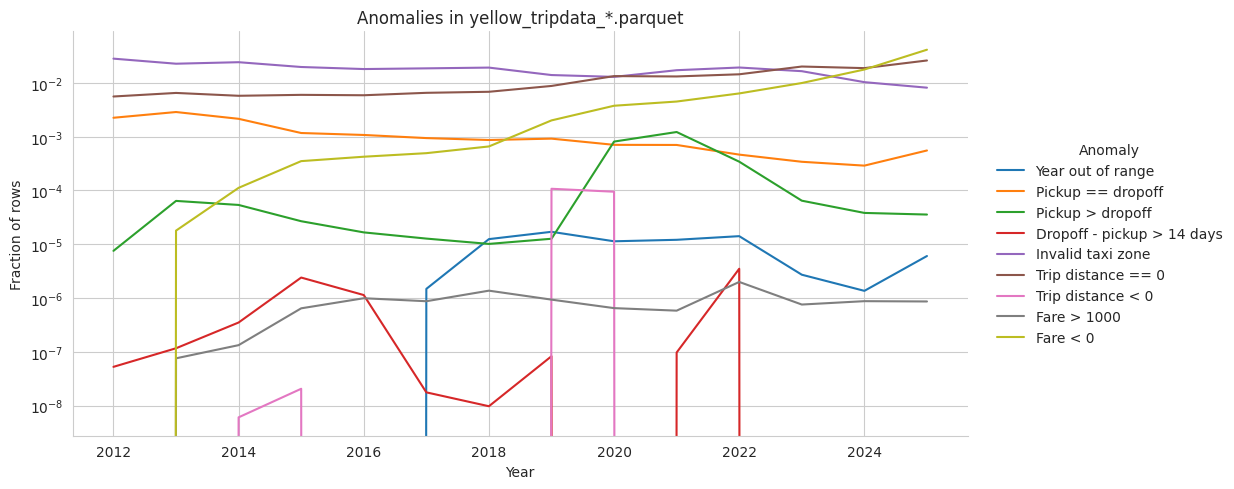

In [5]:
fg = sns.relplot(
    (
        df_yellow.lazy()
        .select("year", pl.exclude("year", "rows") / pl.col("rows"))
        .unpivot(index="year")
        .select(
            pl.col("year").alias("Year"),
            pl.col("variable")
            .replace(
                {
                    "year_out_of_range": "Year out of range",
                    "time_zero": "Pickup == dropoff",
                    "time_negative": "Pickup > dropoff",
                    "time_very_high": "Dropoff - pickup > 14 days",
                    "location_invalid": "Invalid taxi zone",
                    "distance_zero": "Trip distance == 0",
                    "distance_negative": "Trip distance < 0",
                    "fare_very_high": "Fare > 1000",
                    "fare_negative": "Fare < 0",
                }
            )
            .alias("Anomaly"),
            pl.col("value").alias("Fraction of rows"),
        )
        .collect()
    ),
    x="Year",
    y="Fraction of rows",
    hue="Anomaly",
    kind="line",
    aspect=2 / 1,
)
fg.ax.set_title(r"Anomalies in yellow_tripdata_*.parquet")
fg.ax.set_yscale("log")
fg.tight_layout()
savefig(fg.figure, "fig/t2_yellow.pdf")

## Green


In [6]:
def detect_anomalies_green(p: Path, year: int):
    return (
        pl.scan_parquet(p)
        .select(
            year_out_of_range=pl.col("lpep_pickup_datetime").dt.year() != year,
            time_zero=pl.col("lpep_pickup_datetime") == pl.col("lpep_dropoff_datetime"),
            time_negative=(
                pl.col("lpep_pickup_datetime") > pl.col("lpep_dropoff_datetime")
            ),
            time_very_high=(
                (pl.col("lpep_dropoff_datetime") - pl.col("lpep_pickup_datetime"))
                > timedelta(days=14)
            ),
            location_invalid=~(
                (
                    pl.col("PULocationID").is_null()
                    | pl.col("PULocationID").is_between(1, 263)
                )
                & (
                    pl.col("DOLocationID").is_null()
                    | pl.col("DOLocationID").is_between(1, 263)
                )
            ),
            distance_zero=pl.col("trip_distance") == 0,
            distance_negative=pl.col("trip_distance") < 0,
            fare_very_high=pl.col("fare_amount") > 1000,
            fare_negative=pl.col("fare_amount") < 0,
        )
        .select(pl.len().alias("rows"), pl.all().sum())
        .collect(engine="streaming")
        .row(0, named=True)
    )


df_green = detect_anomalies(get_paths_original_green(), detect_anomalies_green)
df_green

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


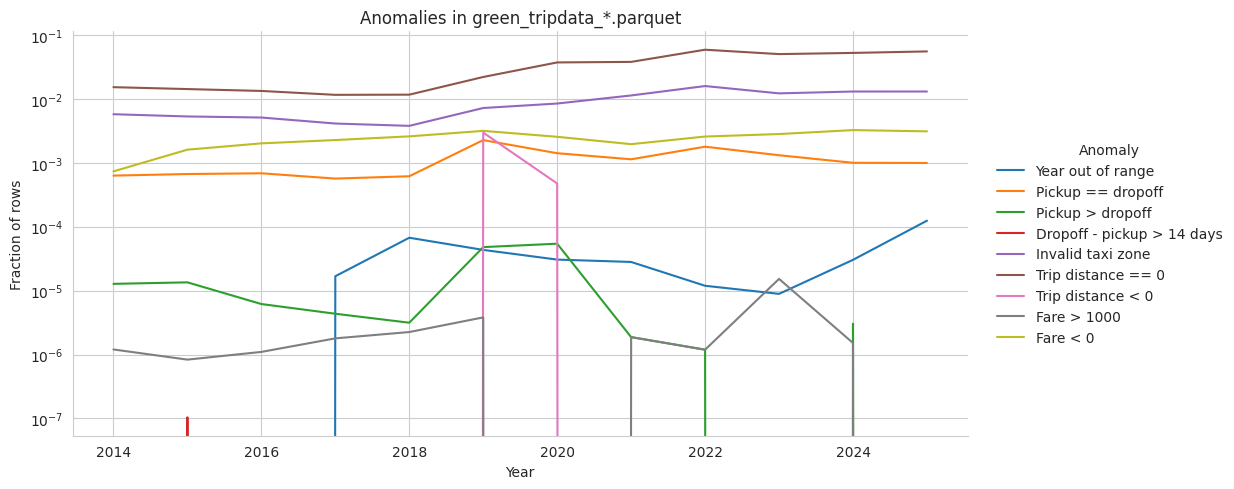

In [7]:
fg = sns.relplot(
    (
        df_green.lazy()
        .select("year", pl.exclude("year", "rows") / pl.col("rows"))
        .unpivot(index="year")
        .select(
            pl.col("year").alias("Year"),
            pl.col("variable")
            .replace(
                {
                    "year_out_of_range": "Year out of range",
                    "time_zero": "Pickup == dropoff",
                    "time_negative": "Pickup > dropoff",
                    "time_very_high": "Dropoff - pickup > 14 days",
                    "location_invalid": "Invalid taxi zone",
                    "distance_zero": "Trip distance == 0",
                    "distance_negative": "Trip distance < 0",
                    "fare_very_high": "Fare > 1000",
                    "fare_negative": "Fare < 0",
                }
            )
            .alias("Anomaly"),
            pl.col("value").alias("Fraction of rows"),
        )
        .collect()
    ),
    x="Year",
    y="Fraction of rows",
    hue="Anomaly",
    kind="line",
    aspect=2 / 1,
)
fg.ax.set_title(r"Anomalies in green_tripdata_*.parquet")
fg.ax.set_yscale("log")
fg.tight_layout()
savefig(fg.figure, "fig/t2_green.pdf")

## FHV


In [8]:
def detect_anomalies_fhv(p: Path, year: int):
    return (
        pl.scan_parquet(p)
        .select(
            year_out_of_range=pl.col("pickup_datetime").dt.year() != year,
            time_zero=pl.col("pickup_datetime") == pl.col("dropOff_datetime"),
            time_negative=pl.col("pickup_datetime") > pl.col("dropOff_datetime"),
            time_very_high=(
                (pl.col("dropOff_datetime") - pl.col("pickup_datetime"))
                > timedelta(days=14)
            ),
            location_invalid=~(
                (
                    pl.col("PUlocationID").is_null()
                    | pl.col("PUlocationID").is_between(1, 263)
                )
                & (
                    pl.col("DOlocationID").is_null()
                    | pl.col("DOlocationID").is_between(1, 263)
                )
            ),
        )
        .select(pl.len().alias("rows"), pl.all().sum())
        .collect(engine="streaming")
        .row(0, named=True)
    )


df_fhv = detect_anomalies(get_paths_original_fhv(), detect_anomalies_fhv)
df_fhv

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


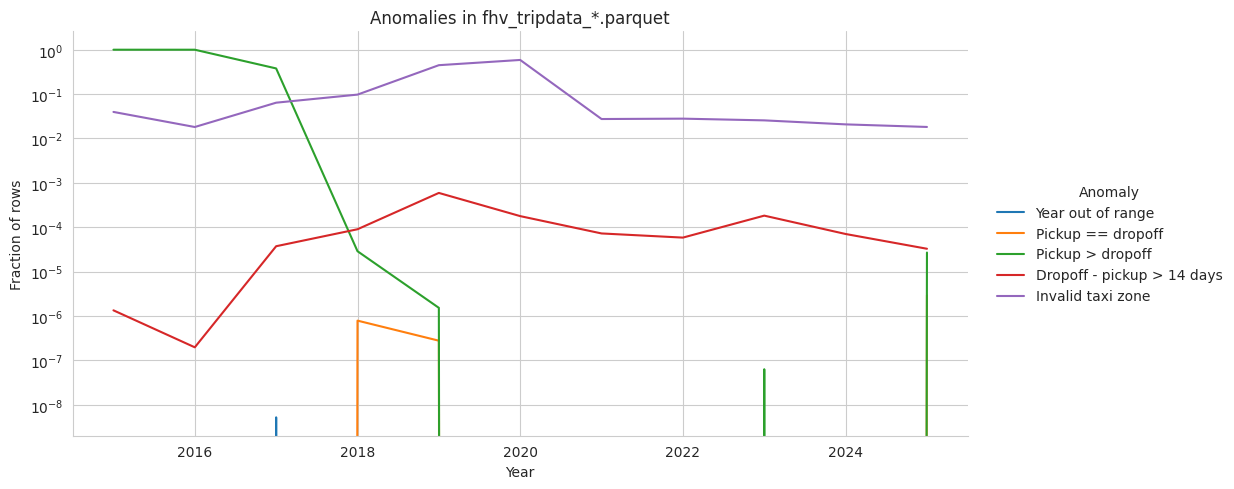

In [9]:
fg = sns.relplot(
    (
        df_fhv.lazy()
        .select("year", pl.exclude("year", "rows") / pl.col("rows"))
        .unpivot(index="year")
        .select(
            pl.col("year").alias("Year"),
            pl.col("variable")
            .replace(
                {
                    "year_out_of_range": "Year out of range",
                    "time_zero": "Pickup == dropoff",
                    "time_negative": "Pickup > dropoff",
                    "time_very_high": "Dropoff - pickup > 14 days",
                    "location_invalid": "Invalid taxi zone",
                }
            )
            .alias("Anomaly"),
            pl.col("value").alias("Fraction of rows"),
        )
        .collect()
    ),
    x="Year",
    y="Fraction of rows",
    hue="Anomaly",
    kind="line",
    aspect=2 / 1,
)
fg.ax.set_title(r"Anomalies in fhv_tripdata_*.parquet")
fg.ax.set_yscale("log")
fg.tight_layout()
savefig(fg.figure, "fig/t2_fhv.pdf")

## FHVHV


In [10]:
def detect_anomalies_fhvhv(p: Path, year: int):
    return (
        pl.scan_parquet(p)
        .select(
            year_out_of_range=pl.col("pickup_datetime").dt.year() != year,
            time_zero=pl.col("pickup_datetime") == pl.col("dropoff_datetime"),
            time_negative=pl.col("pickup_datetime") > pl.col("dropoff_datetime"),
            time_very_high=(
                (pl.col("dropoff_datetime") - pl.col("pickup_datetime"))
                > timedelta(days=14)
            ),
            location_invalid=~(
                (
                    pl.col("PULocationID").is_null()
                    | pl.col("PULocationID").is_between(1, 263)
                )
                & (
                    pl.col("DOLocationID").is_null()
                    | pl.col("DOLocationID").is_between(1, 263)
                )
            ),
            distance_zero=pl.col("trip_miles") == 0,
            distance_negative=pl.col("trip_miles") < 0,
            fare_very_high=pl.col("base_passenger_fare") > 1000,
            fare_negative=pl.col("base_passenger_fare") < 0,
        )
        .select(pl.len().alias("rows"), pl.all().sum())
        .collect(engine="streaming")
        .row(0, named=True)
    )


df_fhvhv = detect_anomalies(get_paths_original_fhvhv(), detect_anomalies_fhvhv)
df_fhvhv

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


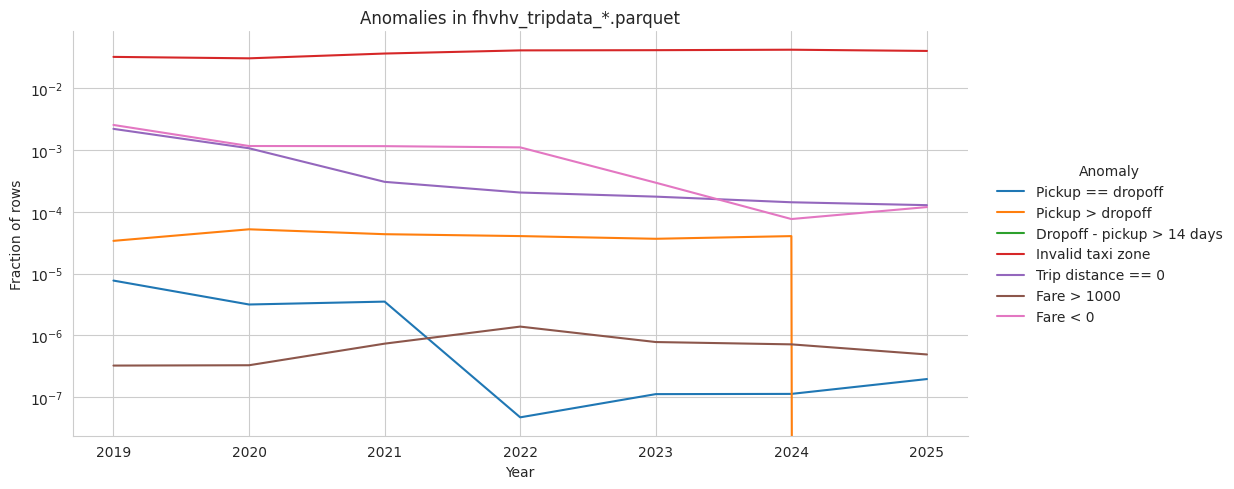

In [11]:
fg = sns.relplot(
    (
        df_fhvhv.lazy()
        .select(
            "year",
            pl.exclude(
                "year",
                "rows",
                "year_out_of_range",
                "distance_negative",
            )
            / pl.col("rows"),
        )
        .unpivot(index="year")
        .select(
            pl.col("year").alias("Year"),
            pl.col("variable")
            .replace(
                {
                    "time_zero": "Pickup == dropoff",
                    "time_negative": "Pickup > dropoff",
                    "time_very_high": "Dropoff - pickup > 14 days",
                    "location_invalid": "Invalid taxi zone",
                    "distance_zero": "Trip distance == 0",
                    "fare_very_high": "Fare > 1000",
                    "fare_negative": "Fare < 0",
                }
            )
            .alias("Anomaly"),
            pl.col("value").alias("Fraction of rows"),
        )
        .collect()
    ),
    x="Year",
    y="Fraction of rows",
    hue="Anomaly",
    kind="line",
    aspect=2 / 1,
)
fg.ax.set_title(r"Anomalies in fhvhv_tripdata_*.parquet")
fg.ax.set_yscale("log")
fg.tight_layout()
savefig(fg.figure, "fig/t2_fhvhv.pdf")

# Anomaly detection (on a map)


In [12]:
def detect_anomalies_geo(
    paths: Iterable[Path],
    fn: Callable[[Path, int], pl.LazyFrame],
) -> pl.DataFrame:
    def wrapper(p: Path):
        year, _ = get_ym_from_fname(p)
        return (
            fn(p, year)
            .unpivot(
                on=["pu_locid", "do_locid"],
                index=["label", "is_err"],
                value_name="locid",
            )
            .filter(pl.col("locid").is_between(1, 263))
            .group_by("label", "locid")
            .agg(pl.len().alias("rows"), pl.col("is_err").sum().alias("errors"))
            .select("label", "locid", "rows", "errors")
            .collect(engine="streaming")
            .rows()
        )

    def binop(total: tuple[int, int], x: tuple[str, int, int, int]):
        return total[0] + x[2], total[1] + x[3]

    def combine(total_a: tuple[int, int], total_b: tuple[int, int]):
        return total_a[0] + total_b[0], total_a[1] + total_b[1]

    return pl.DataFrame(
        data=[
            (label, locid, rows, errors)
            for (label, locid), (rows, errors) in (
                db.from_sequence(paths)
                .map(wrapper)
                .flatten()
                .foldby(lambda x: (x[0], x[1]), binop, (0, 0), combine, (0, 0))
                .compute()
            )
        ],
        schema=["label", "locid", "rows", "errors"],
        orient="row",
    )


def detect_anomalies_universal_geo(p: Path, year: int):
    lf = pl.scan_parquet(p)

    if "tpep_pickup_datetime" in lf:
        return lf.select(
            label=pl.lit("yellow"),
            pu_locid="PULocationID",
            do_locid="DOLocationID",
            is_err=pl.any_horizontal(
                # year_out_of_range
                pl.col("tpep_pickup_datetime").dt.year() != year,
                # time_zero
                pl.col("tpep_pickup_datetime") == pl.col("tpep_dropoff_datetime"),
                # time_negative
                pl.col("tpep_pickup_datetime") > pl.col("tpep_dropoff_datetime"),
                # time_very_high
                (
                    (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime"))
                    > timedelta(days=14)
                ),
                # location_invalid
                ~(
                    (
                        pl.col("PULocationID").is_null()
                        | pl.col("PULocationID").is_between(1, 263)
                    )
                    & (
                        pl.col("DOLocationID").is_null()
                        | pl.col("DOLocationID").is_between(1, 263)
                    )
                ),
                # distance_zero
                pl.col("trip_distance") == 0,
                # distance_negative
                pl.col("trip_distance") < 0,
                # fare_very_high
                pl.col("fare_amount") > 1000,
                # fare_negative
                pl.col("fare_amount") < 0,
            ),
        )
    elif "lpep_pickup_datetime" in lf:
        return lf.select(
            label=pl.lit("green"),
            pu_locid="PULocationID",
            do_locid="DOLocationID",
            is_err=pl.any_horizontal(
                # year_out_of_range
                pl.col("lpep_pickup_datetime").dt.year() != year,
                # time_zero
                pl.col("lpep_pickup_datetime") == pl.col("lpep_dropoff_datetime"),
                # time_negative
                pl.col("lpep_pickup_datetime") > pl.col("lpep_dropoff_datetime"),
                # time_very_high
                (
                    (pl.col("lpep_dropoff_datetime") - pl.col("lpep_pickup_datetime"))
                    > timedelta(days=14)
                ),
                # location_invalid
                ~(
                    (
                        pl.col("PULocationID").is_null()
                        | pl.col("PULocationID").is_between(1, 263)
                    )
                    & (
                        pl.col("DOLocationID").is_null()
                        | pl.col("DOLocationID").is_between(1, 263)
                    )
                ),
                # distance_zero
                pl.col("trip_distance") == 0,
                # distance_negative
                pl.col("trip_distance") < 0,
                # fare_very_high
                pl.col("fare_amount") > 1000,
                # fare_negative
                pl.col("fare_amount") < 0,
            ),
        )
    elif "hvfhs_license_num" in lf:
        return lf.select(
            label=pl.lit("fhvhv"),
            pu_locid="PULocationID",
            do_locid="PULocationID",
            is_err=pl.any_horizontal(
                # year_out_of_range
                pl.col("pickup_datetime").dt.year() != year,
                # time_zero
                pl.col("pickup_datetime") == pl.col("dropoff_datetime"),
                # time_negative
                pl.col("pickup_datetime") > pl.col("dropoff_datetime"),
                # time_very_high
                (
                    (pl.col("dropoff_datetime") - pl.col("pickup_datetime"))
                    > timedelta(days=14)
                ),
                # location_invalid
                ~(
                    (
                        pl.col("PULocationID").is_null()
                        | pl.col("PULocationID").is_between(1, 263)
                    )
                    & (
                        pl.col("DOLocationID").is_null()
                        | pl.col("DOLocationID").is_between(1, 263)
                    )
                ),
                # distance_zero
                pl.col("trip_miles") == 0,
                # distance_negative
                pl.col("trip_miles") < 0,
                # fare_very_high
                pl.col("base_passenger_fare") > 1000,
                # fare_negative
                pl.col("base_passenger_fare") < 0,
            ),
        )
    else:
        return lf.select(
            label=pl.lit("fhv"),
            pu_locid="PUlocationID",
            do_locid="DOlocationID",
            is_err=pl.any_horizontal(
                # year_out_of_range
                pl.col("pickup_datetime").dt.year() != year,
                # time_zero
                pl.col("pickup_datetime") == pl.col("dropOff_datetime"),
                # time_negative
                pl.col("pickup_datetime") > pl.col("dropOff_datetime"),
                # time_very_high
                (
                    (pl.col("dropOff_datetime") - pl.col("pickup_datetime"))
                    > timedelta(days=14)
                ),
                # location_invalid
                ~(
                    (
                        pl.col("PUlocationID").is_null()
                        | pl.col("PUlocationID").is_between(1, 263)
                    )
                    & (
                        pl.col("DOlocationID").is_null()
                        | pl.col("DOlocationID").is_between(1, 263)
                    )
                ),
            ),
        )


df_geo = detect_anomalies_geo(
    chain(
        get_paths_original_yellow(),
        get_paths_original_green(),
        get_paths_original_fhv(),
        get_paths_original_fhvhv(),
    ),
    detect_anomalies_universal_geo,
)
df_geo

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


shapefile not found, downloading...
shapefile download complete.


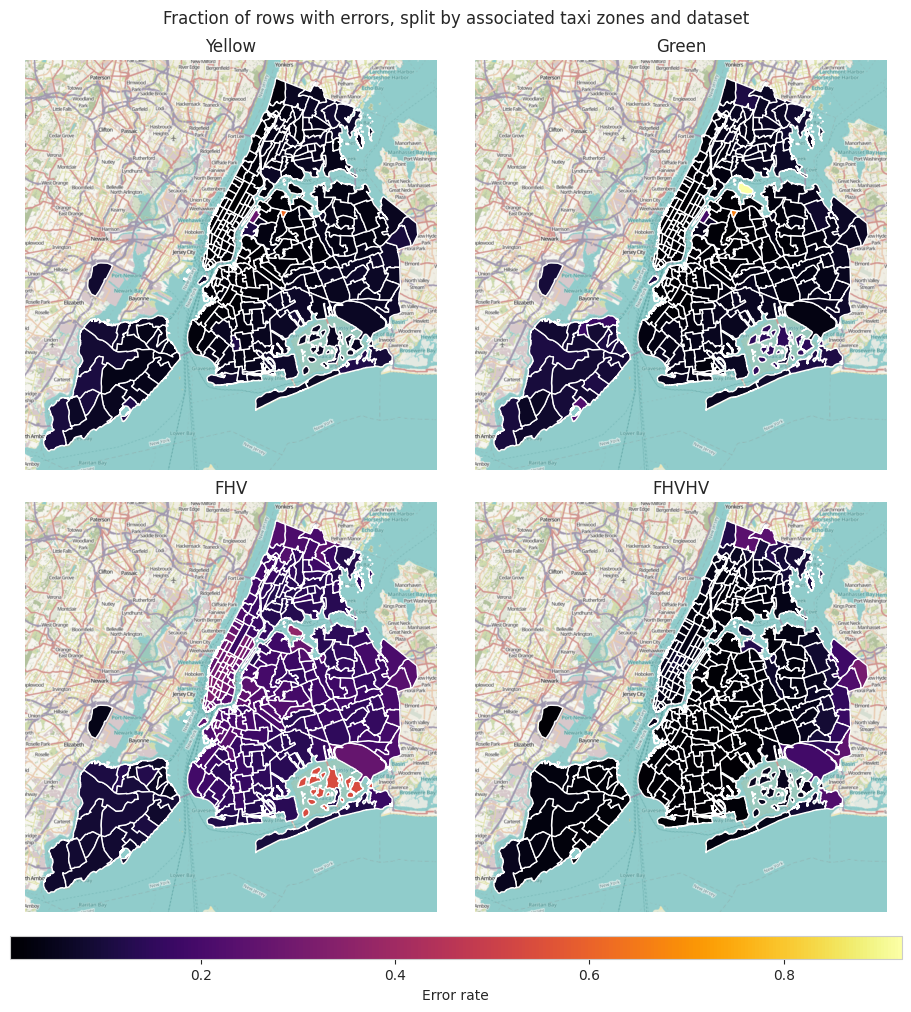

In [13]:
gdf_shapefile = get_gdf_shapefile()

df = df_geo.with_columns(error_rate=pl.col("errors") / pl.col("rows"))

vmin = df["error_rate"].min()
vmax = df["error_rate"].max()
norm = plt.Normalize(vmin, vmax)
cmap = "inferno"


def plot_volume_singleax(df: pl.DataFrame, ax):
    gdf_merged = gdf_shapefile.to_crs(epsg=3857).merge(
        df.to_pandas(),
        how="right",
        left_on="OBJECTID",
        right_on="locid",
    )
    gdf_merged.plot(
        ax=ax,
        column="error_rate",
        cmap=cmap,
        norm=norm,
    )
    contextily.add_basemap(ax, attribution=False)
    ax.axis("off")


fig, axs = plt.subplots(2, 2, figsize=(9, 10), layout="constrained")
((ax1, ax2), (ax3, ax4)) = axs

plot_volume_singleax(df.filter(pl.col("label") == "yellow"), ax1)
ax1.set_title("Yellow")

plot_volume_singleax(df.filter(pl.col("label") == "green"), ax2)
ax2.set_title("Green")

plot_volume_singleax(df.filter(pl.col("label") == "fhv"), ax3)
ax3.set_title("FHV")

plot_volume_singleax(df.filter(pl.col("label") == "fhvhv"), ax4)
ax4.set_title("FHVHV")

fig.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm),
    ax=axs,
    orientation="horizontal",
    aspect=40,
    pad=0.025,
).set_label("Error rate")

fig.set_constrained_layout_pads(h_pad=0.05)
fig.suptitle("Fraction of rows with errors, split by associated taxi zones and dataset")

savefig(fig, "fig/t2_map.pdf")

In [14]:
# Top 5 (per dataset) zones according to error rate
(
    df_geo.with_columns(error_rate=pl.col("errors") / pl.col("rows"))
    .group_by("label")
    .agg(pl.all().top_k_by("error_rate", 5))
    .explode(pl.exclude("label"))
    .to_pandas()
    .merge(
        gdf_shapefile[["OBJECTID", "zone", "borough"]],
        how="left",
        left_on="locid",
        right_on="OBJECTID",
    )
    .drop(columns="OBJECTID")
)

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)
